In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
dftrain = pd.read_csv('../input/titanic/train.csv')
dfeval  = pd.read_csv('../input/titanic/test.csv')

In [3]:
dftrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
dftrain.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
# Missed Values
dftrain.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Data Cleaning:
dftrain.drop(columns=['Ticket','Cabin'],inplace=True)

In [8]:
#replace missing values
dftrain.Embarked= dftrain.Embarked.fillna(dftrain.Embarked.dropna().max())

In [9]:
dftrain['Sex'] = dftrain['Sex'].map({'male': 0, 'female':1}).astype(int)
dftrain['Sex']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int64

In [10]:
#replace missing ages with median, using sex and class
guess_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = dftrain[(dftrain['Sex'] == i) & \
                           (dftrain['Pclass'] == j+1)]['Age'].dropna()
        age_guess = guess_df.median()
        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
print(guess_ages)
for i in range(0, 2):
    for j in range(0, 3):
        dftrain.loc[ (dftrain.Age.isnull()) & (dftrain.Sex == i) & (dftrain.Pclass == j+1),\
                'Age'] = guess_ages[i,j]
dftrain['Age'] = dftrain['Age'].astype(int)

[[40.  30.  25. ]
 [35.  28.  21.5]]


In [11]:
dftrain.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [12]:
#Correlation with the target:
dftrain.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.060291
Pclass        -0.338481
Name: Survived, dtype: float64

Text(0.5, 0, '%Survive')

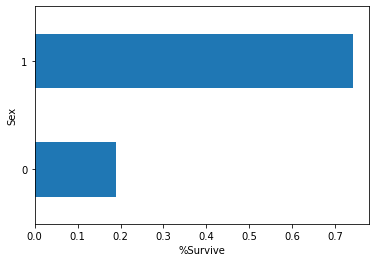

In [13]:
#Sex and Fare -> strong positive 
dftrain.groupby('Sex').Survived.mean().plot(kind='barh').set_xlabel('%Survive')

Text(0.5, 0, '%survive')

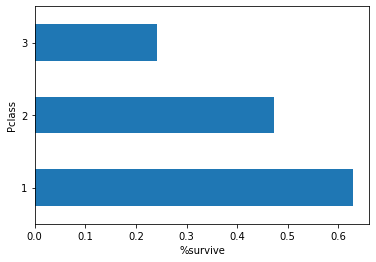

In [14]:
##Pclass -> strong negative
dftrain.groupby('Pclass').Survived.mean().plot(kind='barh').set_xlabel('%survive')

In [15]:
#PassengerId -> very weak 

<AxesSubplot:>

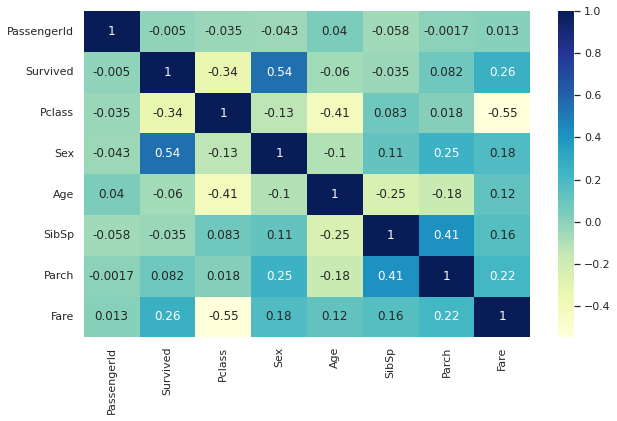

In [16]:
#correlation between all our features
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(dftrain.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

In [17]:
dftrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S


In [18]:
# Not alone data frame i.e. the passenger has either a sibling or a parent.
dftrain['Family'] = dftrain.SibSp + dftrain.Parch
dftrain['Alone'] = dftrain['Family'] ==0

Text(0.5, 0, '%survive')

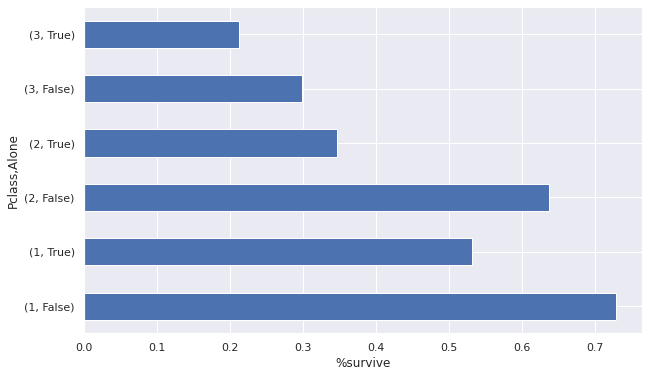

In [19]:
dftrain.groupby(['Pclass','Alone']).Survived.mean().plot(kind='barh').set_xlabel('%survive')

<AxesSubplot:>

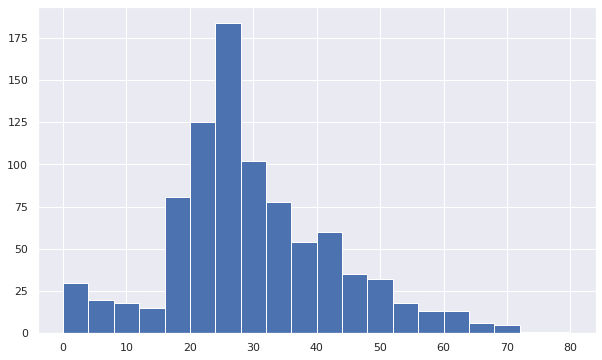

In [20]:
dftrain.Age.hist(bins=20)

In [21]:
dftrain.Age.value_counts()

25    117
21     66
30     36
40     36
24     31
     ... 
12      1
53      1
80      1
66      1
74      1
Name: Age, Length: 71, dtype: int64

In [22]:
#Age group:
dftrain.loc[ dftrain['Age'] <= 16, 'Age'] = 0
dftrain.loc[(dftrain['Age'] > 16) & (dftrain['Age'] <= 32), 'Age'] = 1
dftrain.loc[(dftrain['Age'] > 32) & (dftrain['Age'] <= 48), 'Age'] = 2
dftrain.loc[(dftrain['Age'] > 48) & (dftrain['Age'] <= 64), 'Age'] = 3
dftrain.loc[ dftrain['Age'] > 64, 'Age'] = 4

Text(0.5, 0, '%survive')

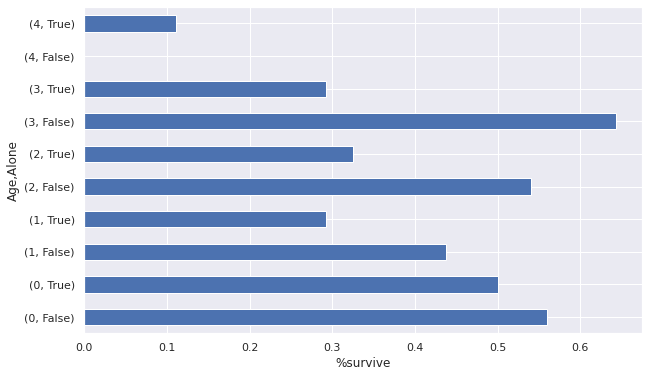

In [23]:
dftrain.groupby(['Age','Alone']).Survived.mean().plot(kind='barh').set_xlabel('%survive')

In [24]:
dftrain.Fare.unique()

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

In [25]:
# Fare Group:
dftrain.loc[ dftrain['Fare'] <= 130, 'Fare'] = 0
dftrain.loc[(dftrain['Fare'] > 130) & (dftrain['Fare'] <= 256), 'Fare'] = 1
dftrain.loc[(dftrain['Fare'] > 256) & (dftrain['Fare'] <= 384), 'Fare'] = 2
dftrain.loc[ dftrain['Fare'] > 384, 'Fare'] = 3
dftrain['Fare'] = dftrain['Fare'].astype(int)

Text(0.5, 0, '%Survive')

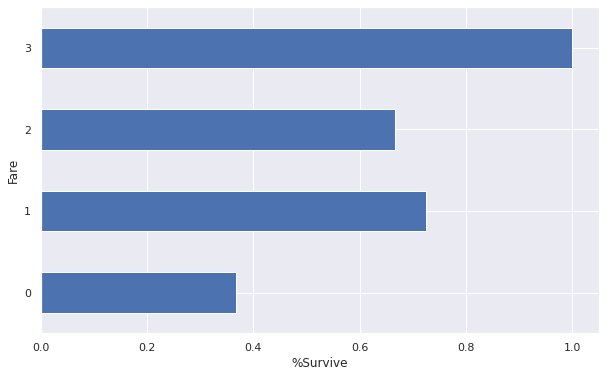

In [26]:
#Fare -> strong positive 
dftrain.groupby(['Fare']).Survived.mean().plot(kind='barh').set_xlabel('%Survive')

In [27]:
# Name Title
dftrain['Title'] = dftrain.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
dftrain.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [28]:
dftrain['Title'] = dftrain['Title'].replace('Mlle', 'Miss')
dftrain['Title'] = dftrain['Title'].replace('Ms', 'Miss')
dftrain['Title'] = dftrain['Title'].replace('Mme', 'Mrs')
dftrain['Title'] = dftrain['Title'].replace(['Lady', 'Countess', 'Dona'], 'Rare-F')
dftrain['Title'] = dftrain['Title'].replace(['Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Rare-M')
dftrain.Title.unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare-M', 'Rare-F'], dtype=object)

In [29]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare-F": 5, "Rare-M": 6}
dftrain['Title'] = dftrain['Title'].map(title_mapping)
dftrain['Title'] = dftrain['Title'].fillna(0)
dftrain.Title.unique()

array([1, 3, 2, 4, 6, 5])

In [30]:
dftrain.drop(columns = ["Name"] , inplace = True)

In [31]:
dftrain.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [32]:
dftrain['Embarked'] = dftrain['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
dftrain.Embarked.unique()

array([0, 1, 2])

In [33]:
dftrain.drop(columns = ["PassengerId"] , inplace = True)
dftrain.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,Title
0,0,3,0,1,1,0,0,0,1,False,1
1,1,1,1,2,1,0,0,1,1,False,3
2,1,3,1,1,0,0,0,0,0,True,2
3,1,1,1,2,1,0,0,0,1,False,3
4,0,3,0,2,0,0,0,0,0,True,1


In [34]:
dftrain.corr()["Survived"].sort_values(ascending=False)


Survived    1.000000
Sex         0.543351
Title       0.373139
Fare        0.147466
Embarked    0.106811
Parch       0.081629
Family      0.016639
SibSp      -0.035322
Age        -0.037059
Alone      -0.203367
Pclass     -0.338481
Name: Survived, dtype: float64

<AxesSubplot:>

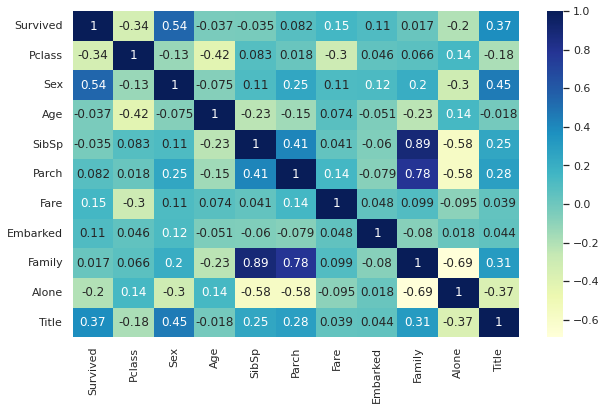

In [35]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(dftrain.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

In [36]:
# ==========================================================================================
# Feature Selection
# We will select best 8 features
# ==========================================================================================
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k=8)

print("Data shape before feature selection:")
print(dftrain.shape)

# apply feature selection
Selected_train_data = fs.fit_transform(dftrain.iloc[:,1:], dftrain["Survived"])
print("Data shape After feature selection:")
print(Selected_train_data.shape)


Data shape before feature selection:
(891, 11)
Data shape After feature selection:
(891, 8)


In [37]:
from sklearn.model_selection import train_test_split
df=dftrain._get_numeric_data()
y_data = df['Survived'] #target variable
x_data = df.drop('Survived', axis=1)#the list of predictive variables
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])
print(f"X_train shape is = {x_train.shape}" )
print(f"Y_train shape is = {y_train.shape}" )

number of test samples : 268
number of training samples: 623
X_train shape is = (623, 10)
Y_train shape is = (623,)


In [38]:
Test = dfeval.drop(labels = ["PassengerId"],axis = 1)
print(f"Test shape is = {Test.shape}" )

Test shape is = (418, 10)
